In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
# import pandas as pd
from scipy.fft import fft

In [2]:
# Load data and print the classes
# TODO: change "gesture_dict.npy" to the filename of your exercise's posture data
data = np.load("overhead.npy",allow_pickle=True)
data.item().keys()


dict_keys(['Posture 1 Good', 'Posture 1 Bad'])

Posture 1 Good (15, 125, 12)


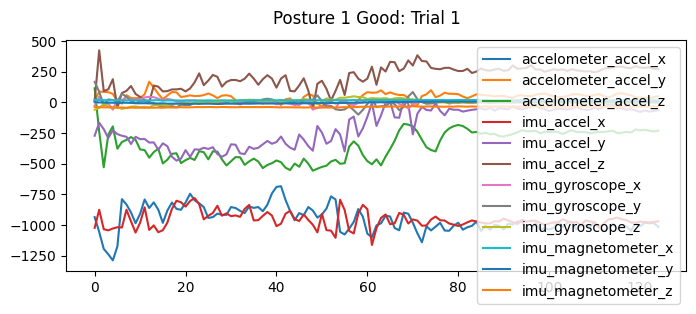

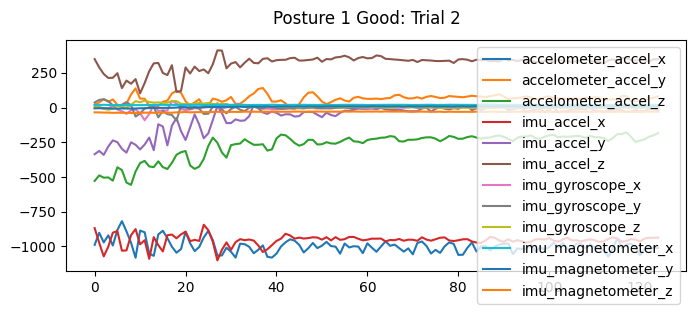

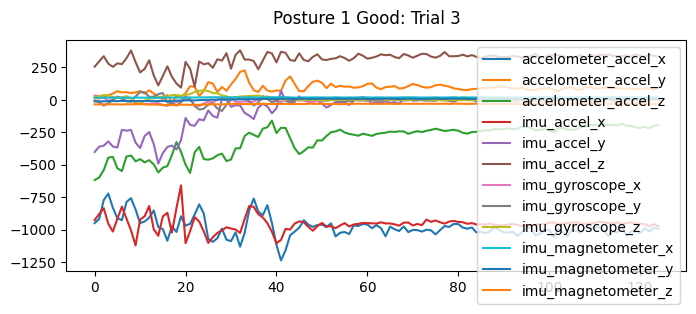

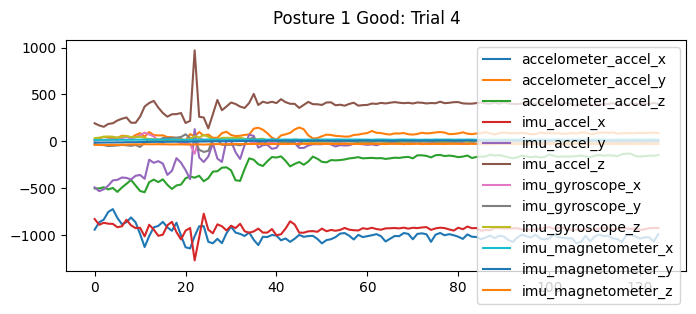

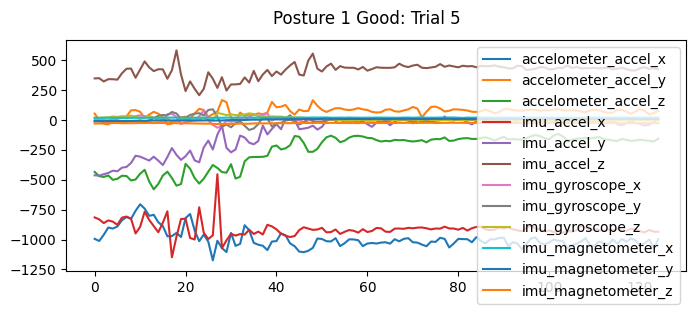

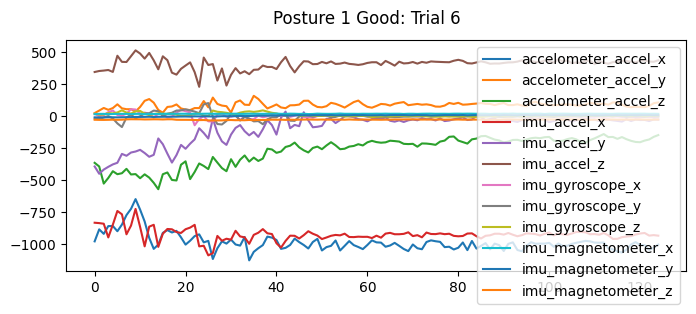

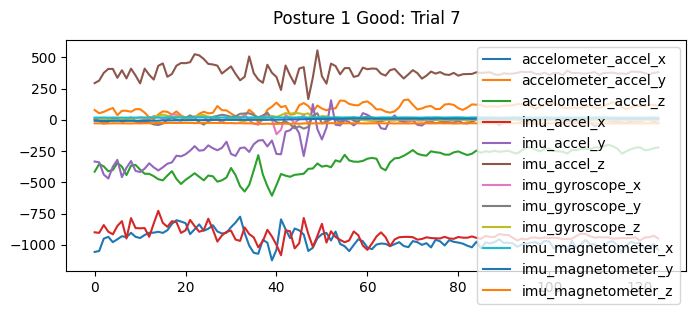

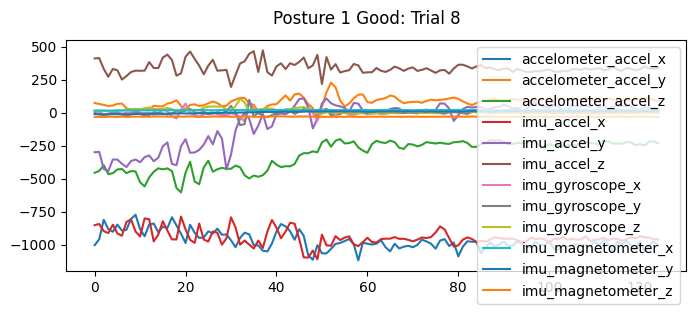

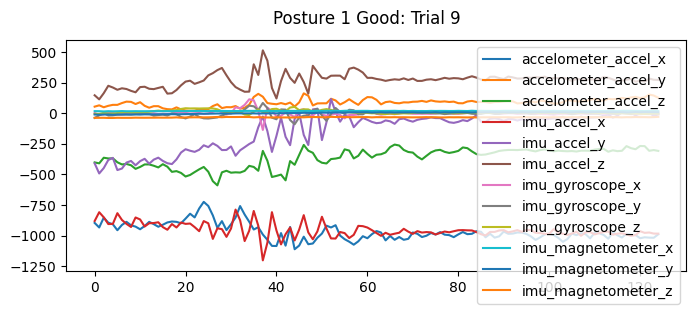

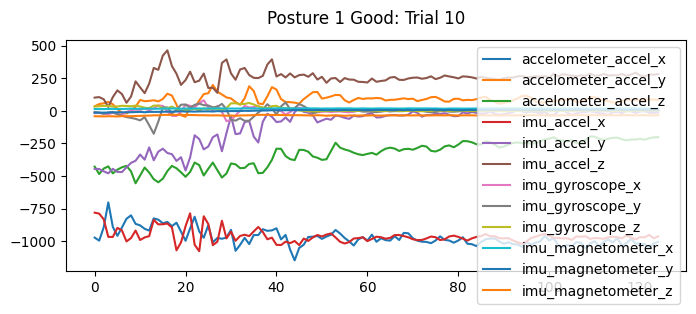

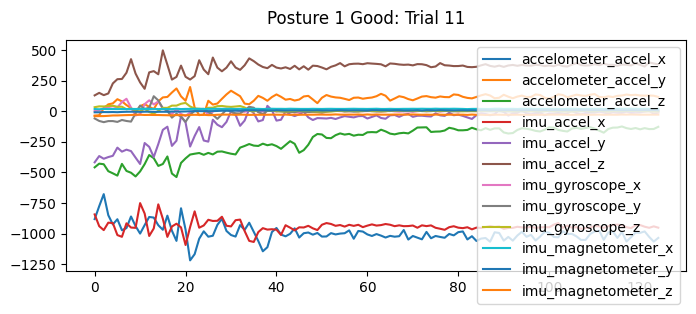

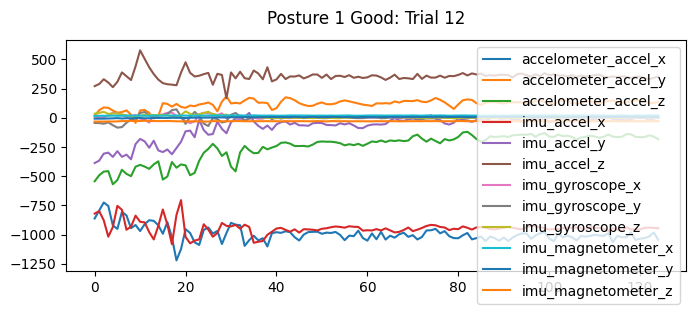

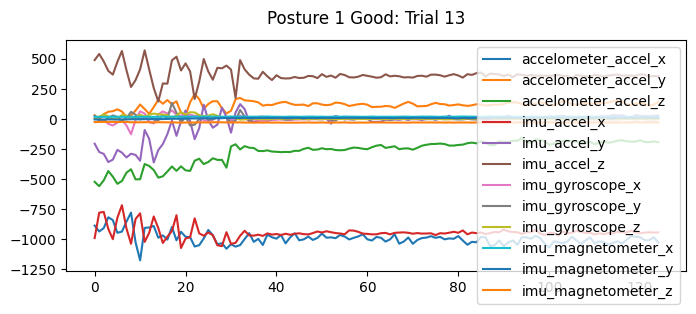

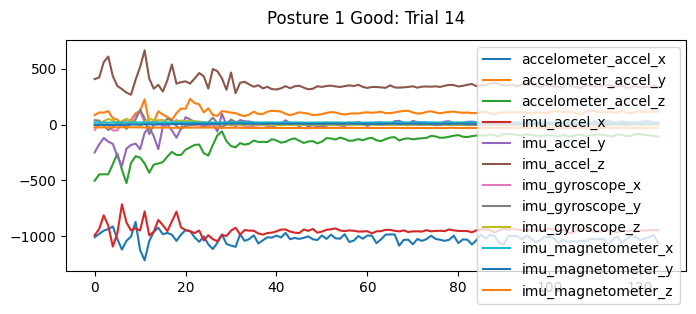

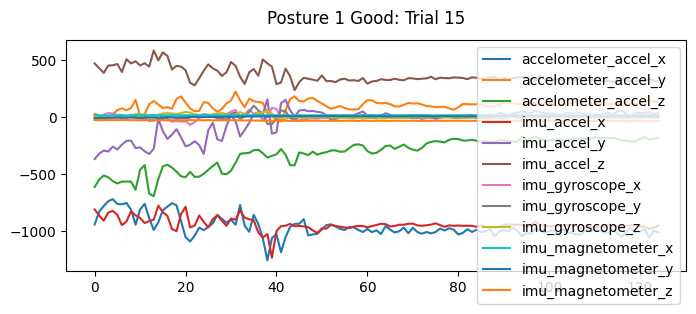

Posture 1 Bad (15, 125, 12)


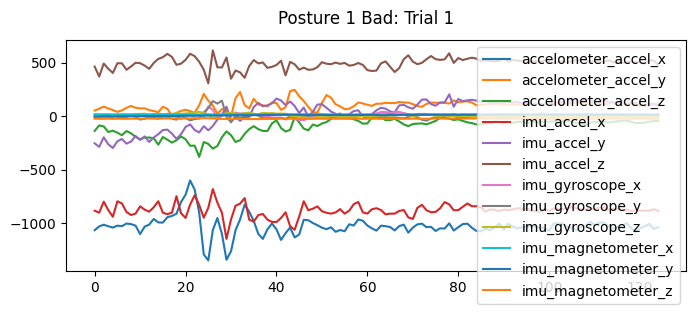

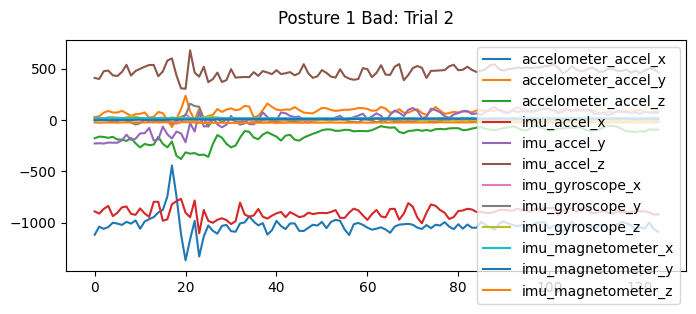

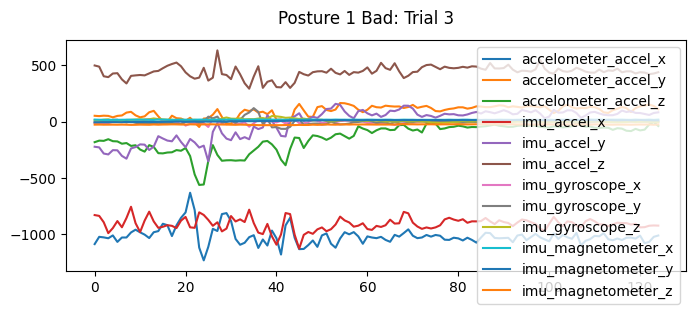

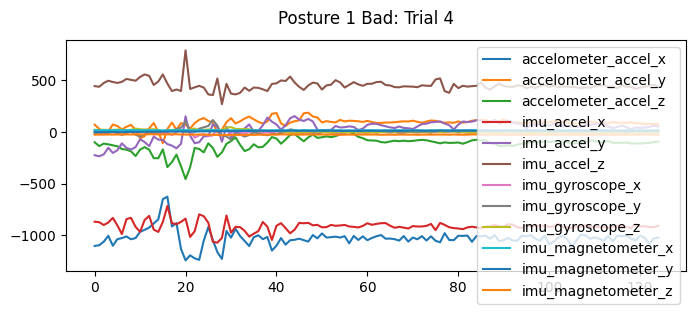

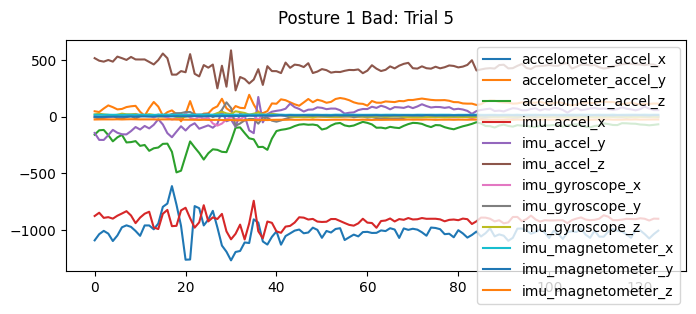

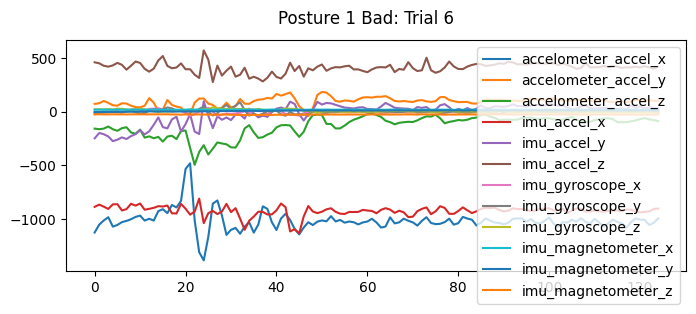

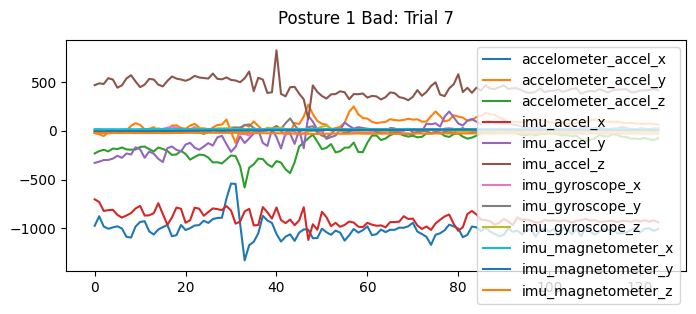

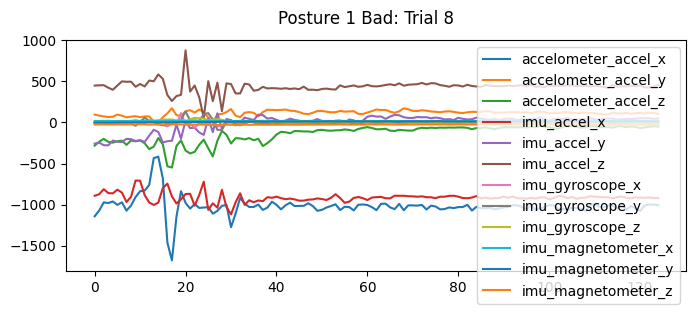

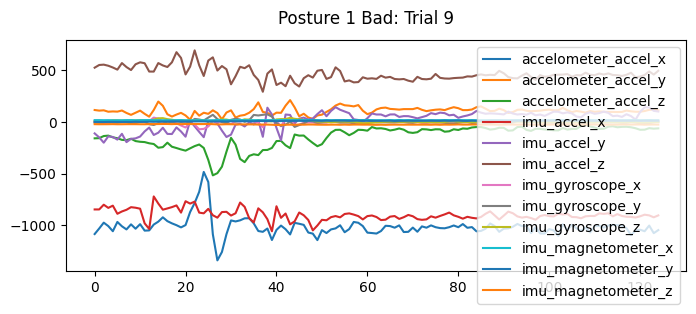

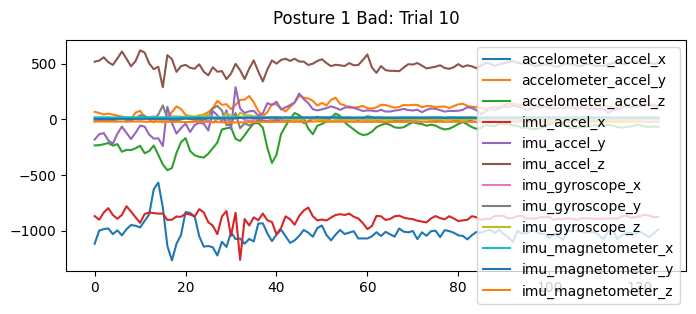

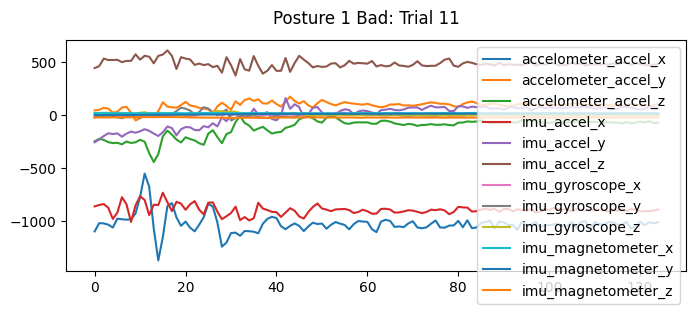

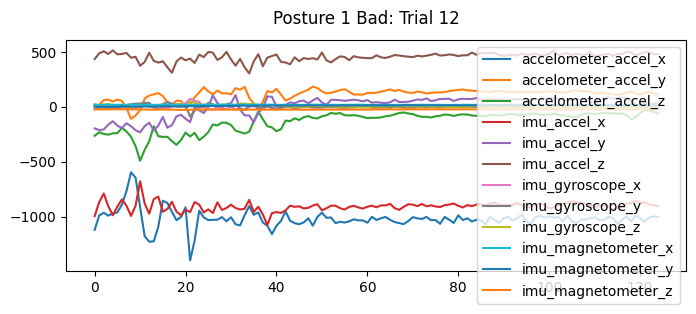

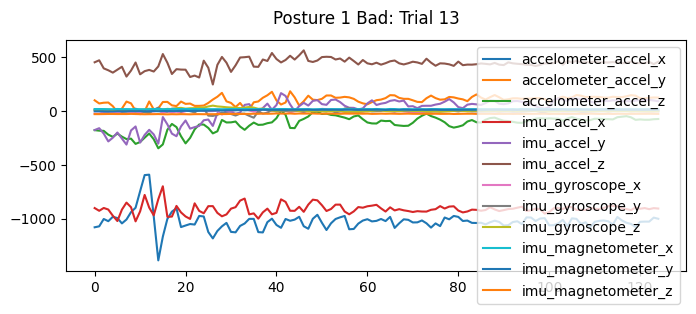

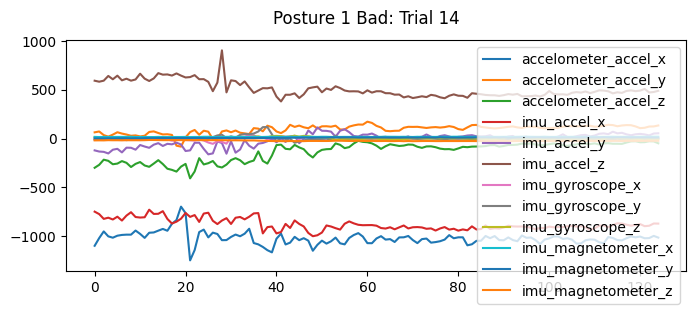

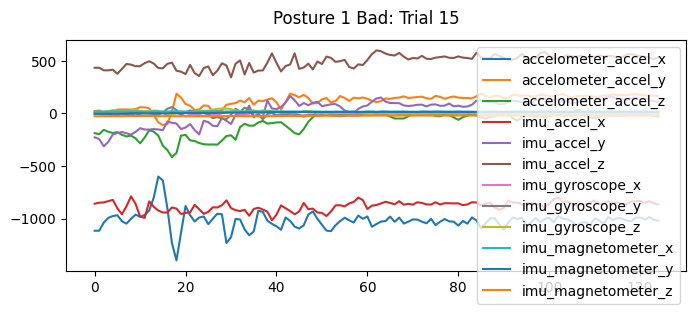

In [3]:
#Code to visualize the different classes
for gesture_key in data.item().keys():
    data_arr = np.array(data.item().get(gesture_key))
    print(gesture_key,data_arr.shape) # Array shape should be n_trials, n_samples, values
    for i in range(len(data_arr)):
        sensor_data = data_arr[i]
        fig, (ax1) = plt.subplots(1, 1,figsize=(8,3))
        fig.suptitle(gesture_key + ": Trial " + str(i+1))
        ax1.plot(sensor_data[:,0],label="accelometer_accel_x") # TODO: change these
        ax1.plot(sensor_data[:,1],label="accelometer_accel_y")
        ax1.plot(sensor_data[:,2],label="accelometer_accel_z")
        ax1.plot(sensor_data[:,3],label="imu_accel_x")
        ax1.plot(sensor_data[:,4],label="imu_accel_y")
        ax1.plot(sensor_data[:,5],label="imu_accel_z")
        ax1.plot(sensor_data[:,6],label="imu_gyroscope_x")
        ax1.plot(sensor_data[:,7],label="imu_gyroscope_y")
        ax1.plot(sensor_data[:,8],label="imu_gyroscope_z")
        ax1.plot(sensor_data[:,9],label="imu_magnetometer_x")
        ax1.plot(sensor_data[:,10],label="imu_magnetometer_y")
        ax1.plot(sensor_data[:,11],label="imu_magnetometer_z")
        ax1.legend()
        plt.show() 

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

WINDOW_SIZE = 5

def median_filter(a):
    window_medians = sp.signal.medfilt(a, WINDOW_SIZE)
    # fig, (ax1) = plt.subplots(1, 1,figsize=(8,3))
    # ax1.plot(a,label="ax")
    # ax1.plot(window_medians,label="smooth_ax")
    # ax1.legend()
    # plt.show() 
    return window_medians

def plot_peaks(a, peaks, min, title):
    plt.plot(a)
    plt.title(title)
    [plt.axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
    [plt.axvline(m, c='C3', linewidth=0.5) for m in min[0]]
    plt.show()

def extract_ax(arr):
    return arr[:, 0:1].flatten()
def extract_ay(arr):
    return arr[:, 1:2].flatten()

# Returns tuple of arrays of x, y peaks
def get_extrema(ax, ay):
    neg_ax = np.negative(ax)
    neg_ay = np.negative(ay)
    ax_peaks = sp.signal.find_peaks(ax, prominence=0.4)
    ay_peaks = sp.signal.find_peaks(ay, prominence=0.4)
    ax_min = sp.signal.find_peaks(neg_ax, prominence=0.4)
    ay_min = sp.signal.find_peaks(neg_ay, prominence=0.4)
    # plot_peaks(ax, ax_peaks, ax_min, "Ax peaks")
    # plot_peaks(ay, ay_peaks, ay_min, "Ay peaks")
    return (ax_peaks, ax_min, ay_peaks, ay_min)

def get_prominence(ax, ax_peaks, ax_mins, ay, ay_peaks, ay_mins):
    neg_ax = np.negative(ax)
    neg_ay = np.negative(ay)
    ax_peak_prominence = sp.signal.peak_prominences(ax, ax_peaks[0])
    ay_peak_prominence = sp.signal.peak_prominences(ay, ay_peaks[0])
    ax_min_prominence = sp.signal.peak_prominences(neg_ax, ax_mins[0])
    ay_min_prominence = sp.signal.peak_prominences(neg_ay, ay_mins[0])
    return (ax_peak_prominence, ax_min_prominence, ay_peak_prominence, ay_min_prominence)

def get_feature_conditional(peaks, prominences, mode):
    if peaks[0].shape[0] == 0:
        return 0
    elif mode == 'AVG':
        return np.average(prominences[0])
    elif mode == 'SUM':
        return np.sum(prominences[0])
    elif peaks[0].shape[0] == 1 and mode == 'AVG-GAP':
        return 0
    elif mode == 'AVG-GAP':
        return np.average(np.diff(prominences[0]))

# Make changes here for the featurization code
def featurize(arr):
    fvec = np.std(arr,axis=0)
    #     fvec = arr.flatten() #Uncomment this to see the difference in performance
    return fvec
    # ### amy
	# ax = median_filter(extract_ax(arr))
	# ay = median_filter(extract_ay(arr))
	# (ax_peaks, ax_mins, ay_peaks, ay_mins) = get_extrema(ax, ay)
	# (ax_peak_prominence, ax_min_prominence, ay_peak_prominence, ay_min_prominence) = get_prominence(ax, ax_peaks, ax_mins, ay, ay_peaks, ay_mins)
	# fvec = []
	# fvec.append(ax_peaks[0].shape[0]) # number of ax peaks
	# fvec.append(ay_peaks[0].shape[0]) # number of ay peaks
	# fvec.append(get_feature_conditional(ax_peaks, ax_peak_prominence, 'AVG')) # average prominence of ax maxima
	# fvec.append(get_feature_conditional(ay_peaks, ay_peak_prominence, 'AVG')) # average prominence of ay maxima
	
	# ### nandini
	# X_cord = arr[:, 0]
	# Y_cord = arr[:, 1]
	# Z_cord = arr[:, 2]
	# X_fft = np.abs(fft(X_cord))
	# Y_fft = np.abs(fft(Y_cord))
	# Z_fft = np.abs(fft(Z_cord))
	# fv = []
	# fv.append(np.mean(X_fft))
	# fv.append(np.mean(Y_fft))
	# fv.append(np.mean(Z_fft))
	# fv.append(np.max(X_fft))
	# fv.append(np.max(Y_fft))
	
	# ### alejandro
	# features = []
	# # Standard Deviation
	# features.append(np.std(arr, axis=0))
	# # Mean of absolute values
	# features.append(np.mean(np.abs(arr), axis=0))
	# # Max-Min difference
	# features.append(np.max(arr, axis=0) - np.min(arr, axis=0))
	# # Sum of absolute values
	# features.append(np.sum(np.abs(arr), axis=0))
	# # Sum of squares
	# features.append(np.sum(np.square(arr), axis=0))
	# features = np.concatenate(features)

	# return np.concatenate((fvec,fv,features))

# gesture_dict = data.item()
# loo = LeaveOneOut()
# X = []
# Y = []
# for key in gesture_dict.keys():
#     gest_trials = gesture_dict[key]
#     for trial in gest_trials:
#         X.append(featurize(trial))
#         Y.append(key)
# X = np.array(X)
# Y = np.array(Y)

# classifiers = [SVC(kernel='poly'),KNeighborsClassifier(),RandomForestClassifier()]

# for clf_model in classifiers:
#     training_accuracy = []
#     accuracy = []
#     permutation_importances = []
#     for train_index, test_index in loo.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = Y[train_index], Y[test_index]
#         clf_model.fit(X_train, y_train)
#         # print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

#         result_train = permutation_importance(clf_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2).importances_mean
#         # print(result_train, sorted_importances_idx_train)
#         permutation_importances.append(result_train)
    
#         training_accuracy.append(clf_model.score(X_train, y_train))
#         accuracy.append(clf_model.score(X_test, y_test))
#     print("Leave one trial out cross-val accuracy for",clf_model,"is", np.mean(accuracy))
#     print("Training accuracies of",clf_model,"is",training_accuracy)
#     print("Mean permutation importances", np.mean(permutation_importances, axis=0)) # TODO: check if this axis is correct
#     print("Features in order of importance:", np.mean(permutation_importances, axis=0).argsort())
#     # feature importance: https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

gesture_dict = data.item()
X = []
Y = []

# Featurize and create X, Y
for key in gesture_dict.keys():
    gest_trials = gesture_dict[key]
    for trial in gest_trials:
        X.append(featurize(trial))
        Y.append(key)

X = np.array(X)
Y = np.array(Y)

# Define classifiers
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel='poly'),
    RandomForestClassifier()
]

# Train-test split instead of LOOCV
for clf_model in classifiers:
    accuracy = []
    for _ in range(10):  # Perform 10 train-test splits
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        clf_model.fit(X_train, y_train)
        accuracy.append(clf_model.score(X_test, y_test))
    print("Train-test split accuracy for", clf_model, "is", np.mean(accuracy))

Train-test split accuracy for KNeighborsClassifier() is 0.8333333333333334
Train-test split accuracy for SVC(kernel='poly') is 0.8333333333333334
Train-test split accuracy for RandomForestClassifier() is 0.9666666666666668
